In [1]:
import numpy as np
import matplotlib.pyplot as plt

from robot_utils.robot_data.img_data import ImgData
from robot_utils.robot_data.pose_data import PoseData
from robot_utils.transform import transform

import sys
sys.path.append("/home/masonbp/ford/fastsam3d")

from segment_track.observation import Observation
from segment_track.segment import Segment
from segment_track.tracker import Tracker
from segment_track.fastsam_wrapper import FastSAMWrapper

from object_map_registration.object.object import Object
from object_map_registration.object.ellipsoid import Ellipsoid
from object_map_registration.register.clipper_pt_registration import ClipperPtRegistration
from object_map_registration.register.dist_vol_sim_reg import DistVolSimReg

In [2]:
bag = "/home/masonbp/data/motlee_jan_2024/00/RR08.bag"
img_data = ImgData(
    data_file=bag,
    file_type='bag',
    topic="/RR08/d455/color/image_raw/compressed",
    time_tol=.0333333,
)
pose_data = PoseData(
    data_file=bag,
    file_type='bag',
    topic="/RR08/world",
    time_tol=.4,
    interp=True
)
t0 = np.max([img_data.t0, pose_data.t0])
img_data.set_t0(img_data.t0 - t0)
pose_data.set_t0(pose_data.t0 - t0)

<Axes: xlabel='x', ylabel='y'>

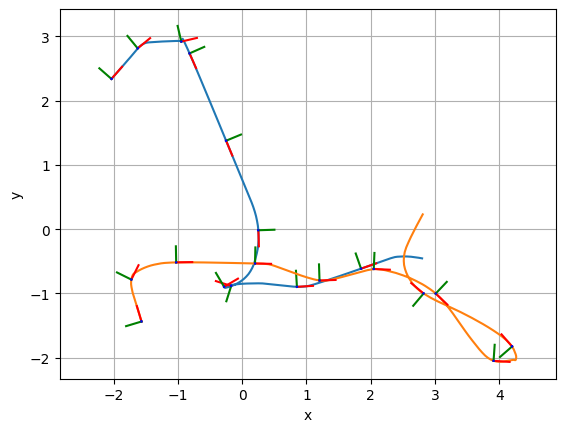

In [3]:
pose_data.plot2d(t0=100, tf=120, pose=False, dt=.1)
pose_data.plot2d(t0=100, tf=120, trajectory=False, pose=True, dt=2., axis_len=.25)
pose_data.plot2d(t0=200, tf=220, pose=False, dt=.1)
pose_data.plot2d(t0=200, tf=220, trajectory=False, pose=True, dt=2., axis_len=.25)
# pose_data.plot2d(t0=t0, tf=tf, trajectory=True, pose=True, dt=2., axis_len=.25)

In [4]:
# T_BC = np.array([
#     - 0.0075156724929106855, 0.052520932013504995, 0.9985915413057593, 0.2101108603826516, - -0.999948500695071, -0.00641591694631477, 0.007863330555028802, 
#     -0.012497043173790775, - 0.00681986984179056, -0.9985992127526291, 0.05247000729150186, -0.0018691769405706252, - 0.0, 0.0, 0.0, 1.0
# ]).reshape((4, 4))

T_BC = np.array([0.031700555562911625, -0.03613229685936231, -0.9988440978954973, -0.3474637078784243, 0.9994936165740449, 
                 0.003899694308407531, 0.03158010152037666, -0.006910240015390966, 0.0027541250405664908, -0.9993394065621388, 0.03623762253919305, -0.11367298866636036, 0.0, 0.0, 0.0, 1.0
]).reshape((4, 4))
pose_data.T_postmultiply = T_BC
img_data.extract_params("/RR08/d455/color/camera_info")
cam_params = img_data.camera_params
fastsam = FastSAMWrapper(
    weights="/home/masonbp/tools/fastsam/weights/FastSAM-x.pt",
    imgsz=256,
    device='cuda'
)
img_area = cam_params.width * cam_params.height
fastsam.setup_filtering(
    ignore_people=True,
    yolo_det_img_size=(128, 128),
    allow_tblr_edges=[True, False, False, False],
    area_bounds=[img_area / 20**2, img_area / 3**2]
)


Fusing layers... 


In [5]:
all_observations = [[], []]
ts = [[100, 120], [200, 220]]
for i in range(2):
    for t in np.arange(ts[i][0], ts[i][1], .05):
        try:
            img = img_data.img(t)
            pose = pose_data.T_WB(t)
        except:
            continue
        observations = fastsam.run(t, pose, img)
        all_observations[i].append(observations)
        
# print(segment.observations)
# print(len(segment.observations))


/home/masonbp/.envs/sparse_map/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

0: 160x256 8 objects, 53.3ms
Speed: 0.5ms preprocess, 53.3ms inference, 343.1ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 9 objects, 12.3ms
Speed: 0.4ms preprocess, 12.3ms inference, 2.5ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 8 objects, 12.3ms
Speed: 0.4ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 9 objects, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 7 objects, 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 7 objects, 12.2ms
Sp

In [6]:
trackers = [Tracker(
    camera_params=cam_params,
    pixel_std_dev=10.0,
    min_iou=0.5,
    min_sightings=3,
    max_t_no_sightings=0.25
) for _ in range(2)]

for i in range(2):
    for observations in all_observations[i]:
        if len(observations) > 0:
            trackers[i].update(observations[0].time, observations)


In [7]:
boxes = np.array([
    [2.33, -2.03], [2.16, -1.65], [4.2, 0.5], [4.48, 1.73], [5.05, 3.24], [5.42, 3.43], 
    [2.28, 1.94], [1.98, 2.19], [0.41, 2.39], [0.07, 2.64], [1.03, .48], [-1., 1.63], 
    [-.86, -1.42], [-.33, -1.83], [-.73, -1.97], [-0.3, -3.46], [-1.79, 0.5], [-1.89, 1.13], 
    [-2.86, 2.74], [-2.61, 2.78], [-3.37, 0.67], [-3.03, 0.19], [-2.36, -1.52],
])

In [8]:
# from dataclasses import dataclass
# import numpy as np

# @dataclass
# class Cylinder():
#     """
#     A cylinder object
#     """
#     position: np.array
#     radius: float
#     height: float
    

# def merge(self):
#     """
#     Merge segments with high overlap
#     """
#     max_iter = 100
#     n = 0
#     edited = True

#     to_delete = []
#     for seg in self.segment_graveyard:
#         try:
#             seg.reconstruction3D(width_height=True)
#         except:
#             to_delete.append(seg)
#     for seg in to_delete:
#         self.segment_graveyard.remove(seg)

#     # repeatedly try to merge until no further merges are possible
#     while n < max_iter and edited:
#         edited = False
#         n += 1

#         for i, seg1 in enumerate(self.segment_graveyard):
#             for j, seg2 in enumerate(self.segment_graveyard):
#                 if i >= j:
#                     continue
#                 reconstruction = seg1.reconstruction3D(width_height=True)
#                 c1 = Cylinder(reconstruction[:3], 0.5*reconstruction[3], reconstruction[4])
#                 reconstruction = seg2.reconstruction3D(width_height=True)
#                 c2 = Cylinder(reconstruction[:3], 0.5*reconstruction[3], reconstruction[4])
#                 intersection = self.cylinder_intersection(c1, c2)
#                 combined_vol = c1.height * np.pi * c1.radius**2 + \
#                     c2.height * np.pi * c2.radius**2
#                 iou = intersection / (combined_vol - intersection)
#                 if iou > self.merge_objects_iou:
#                     for obs in seg2.observations:
#                         seg1.update(obs)
#                     self.segment_graveyard.pop(j)
#                     edited = True
#                     break
#             if edited:
#                 break
#     return

# def cylinder_intersection(self, c1: Cylinder, c2: Cylinder):
#     """
#     Compute the intersection volume between two cylinders
#     """
#     d = np.linalg.norm(c1.position[:2] - c2.position[:2])
#     if np.abs(c1.position[2] - c2.position[2]) > 0.5 * (c1.height + c2.height) \
#         or d > c1.radius + c2.radius: # no intersection
#         return 0.0
#     intersecting_height = \
#         (np.min([c1.position[2] + 0.5*c1.height, c2.position[2] + 0.5*c2.height]) # top
#         - np.max([c1.position[2] - 0.5*c1.height, c2.position[2] - 0.5*c2.height])) # bottom
#     if d <= np.abs(c1.radius - c2.radius): # one cylinder is inside the other
#         return np.pi * np.min([c1.radius, c2.radius])**2 * intersecting_height
#     r1 = c1.radius
#     r2 = c2.radius
#     return (r1**2 * np.arccos((d**2 + r1**2 - r2**2) / (2 * d * r1)) \
#         + r2**2 * np.arccos((d**2 + r2**2 - r1**2) / (2 * d * r2)) \
#         - 0.5 * np.sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2))) \
#         * intersecting_height
            
# merge(trackers[0])

missed this one


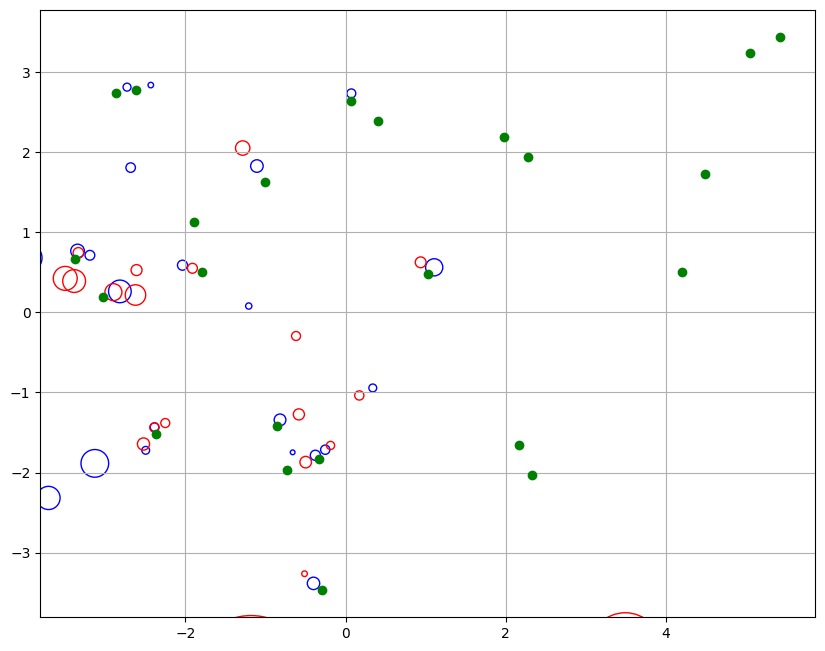

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(boxes[:,0], boxes[:,1], 'go')
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
maps = [[], []]

formats = ['bx', 'r+']
colors = ['blue', 'red']

for i in range(2):
    trackers[i].merge()
    for segment in trackers[i].segments + trackers[i].segment_graveyard:
        try:
            if segment.num_sightings < 10: continue
            reconstruction = segment.reconstruction3D(width_height=True)
            # position, width = reconstruction[:2], reconstruction[3]
            # ellipsoid = Ellipsoid(reconstruction[:2], axes=np.array([width/2, width/2]), rot_mat=np.eye(2))
            position, width, height = reconstruction[:3], reconstruction[3], reconstruction[4]
            ellipsoid = Ellipsoid(reconstruction[:3], axes=np.array([width/2, width/2, height/2]), rot_mat=np.eye(3))
            maps[i].append(ellipsoid)
            maps[i][-1].plot2d(ax, edgecolor=colors[i])
        except:
            print("missed this one")

In [58]:
clipper = ClipperPtRegistration(sigma=.2, epsilon=.4)
inliers_cl = clipper.register(maps[0], maps[1])
print(inliers_cl)

[[22 20]
 [14 27]
 [21 12]
 [20 22]
 [15 15]
 [ 2 11]
 [24 21]
 [13 32]
 [26 14]
 [11 19]
 [29  4]]


In [30]:
from motlee.realign.frame_aligner import FrameAligner, AssocMethod
frame_aligner = FrameAligner(
    method=AssocMethod.CLIPPER_MULT_SOL,
    clipper_sigma=.2,
    clipper_epsilon=.4,
    clipper_mult_downweight=0.0,
    clipper_mult_repeats=10
)
centroids1 = np.array([ellipsoid.centroid.reshape(-1) for ellipsoid in maps[0]])
centroids2 = np.array([ellipsoid.centroid.reshape(-1) for ellipsoid in maps[1]])
sols = frame_aligner.align_objects(static_objects=[centroids1, centroids2])


In [55]:
dist_vol_reg = DistVolSimReg(sigma=.2, epsilon=.4, vol_score_min=.5, dist_score_min=.5)
inliers = dist_vol_reg.register(maps[0], maps[1])
print(inliers)

[[14 27]
 [24 21]
 [20 22]
 [22 20]
 [16 13]
 [21 16]
 [13 32]
 [ 0 30]
 [15 15]
 [29  4]
 [23 26]
 [26 14]
 [27 25]]


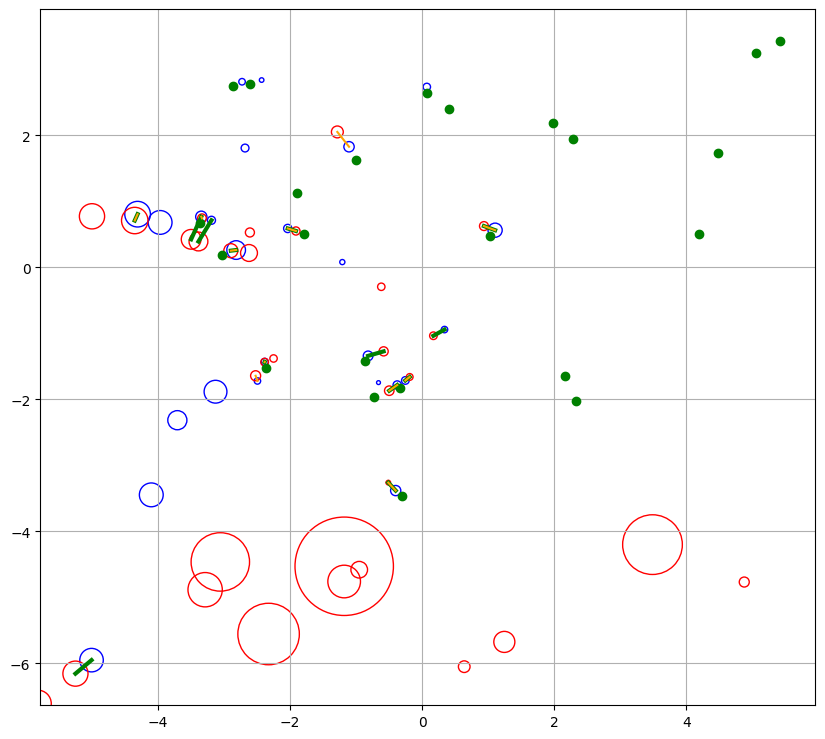

In [67]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(boxes[:,0], boxes[:,1], 'go')
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
colors = ['blue', 'red']

for i in range(2):
    for obj in maps[i]:
        ax = obj.plot2d(ax, edgecolor=colors[i])

for pair in inliers:
# for pair in sols[9].associated_objs:
    ax.plot([maps[0][pair[0]].centroid[0], maps[1][pair[1]].centroid[0]], [maps[0][pair[0]].centroid[1], maps[1][pair[1]].centroid[1]], 'g-', linewidth=3)

for pair in inliers_cl:
    ax.plot([maps[0][pair[0]].centroid[0], maps[1][pair[1]].centroid[0]], [maps[0][pair[0]].centroid[1], maps[1][pair[1]].centroid[1]], color='orange')
